<center>

# Discrete Event Systems

## Home Assignment 1

### Synchronization and Reachability Analysis

- - -

# Introduction

The objective of the home assignment is to get a deeper understanding of some basic features of discrete event systems. This will be achieved by implementing a few key functions in Python, including the computation of reachable and coreachable states, as well as the synchronous composition of two automata. These functions are then applied to the analysis of a simple coordination control system.

This home assignment is performend in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on PingPong**

## Comments and Recommendations

* Whitespaces do matter in Python! Always check that you have the right amount of indentation. If you need a refresher on programming in Python check [this](https://wiki.python.org/moin/BeginnersGuide/Programmers) out, where you can find links to tutorials like [Google's Python class](https://developers.google.com/edu/python/). Wikipedia also has a great overview of [Python's syntax and semantics](https://en.wikipedia.org/wiki/Python_syntax_and_semantics). [learnpython.org](https://www.learnpython.org/) is a great resource too.
* We will work extensively with **sets** in this assignment. A set is created either through `set( )` or by listing its elements between curly braces `{*iterable*}`. An empty set must be created by `set()`. `{}` will create an empty dictionary. You will also see often something like `{elem for elem in items if elem}`. This is called a *set comprehension* and builds efficiently a new set by iterating over `items` and adding the `elem` for which the if-statement is true. Have an extensive look at [the set documentation](https://docs.python.org/3.6/library/stdtypes.html#set) for more information on set methods.  
* This assignment is written for Python 3.5 or later! Executing it with Python version 2.7 won't work.
* If you get stuck with Python or Jupyter, try to google it! E.g. your search query could be *"python --INSERT ERROR HERE--"*. Chances are high, heaps of people had the same problem before you.
* To show line numbers in a cell, go to *View* and click on *Toggle Line Numbers*.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! We will test your code with additional edge cases. So convice yourself that everything is correct before you submit.

- - -

# Preliminaries

The code below defines the transition and the automaton class. Transitions are implemented as [named tuples](https://docs.python.org/3.6/library/collections.html?highlight=collections#collections.namedtuple). It also creates two automata **P1** and **P2**. You do not need to change anything here, but make sure you understand the code. 

In [1]:
from collections import namedtuple


Transition = namedtuple(typename='Transition', field_names=['source', 'event', 'target'])


class Automaton(object):
    
    def __init__(self, states, init, events, trans, marked=None, forbidden=None):
        """
        This is the constructor of the automaton. 
        
        At creation, the automaton gets the following attributes assigned:
        :param states: A set of states
        :param init: The initial state
        :param events: A set of events
        :param transitions: A set of transitions
        :param marked: (Optional) A set of marked states
        :param forbidden: (Optional) A set of forbidden states
        """
        self.states = self._validate_set(states)
        self.init = self._validate_init(init)
        self.events = self._validate_set(events)
        self.trans = self._validate_transitions(trans)
        self.marked = self._validate_subset(marked) if marked else set()
        self.forbidden = self._validate_subset(forbidden) if forbidden else set()
    
    def __str__(self):
        return 'states: \n\t{}\ninit: \n\t{}\nevents: \n\t{}\ntransitions: \n\t{}\nmarked: \n\t{}\nforbidden: \n\t{}\n'.format(
            self.states, self.init, self.events, '\n\t'.join([str(t) for t in self.trans]), self.marked, self.forbidden)
        
    @staticmethod
    def _validate_set(states):
        """
        Checks that states is a set and the states in it are strings or integers.
        """
        assert isinstance(states, set)
        for state in states:
            assert isinstance(state, str) or isinstance(state, int), 'A state must be \
                either of type string or integer!'
        return states
    
    def _validate_subset(self, subset):
        """
        Validates the set and checks whether the states in the subset are part of the state set.
        """
        subset = self._validate_set(subset)
        assert subset.issubset(self.states), 'Marked and forbidden states must be subsets of all states!'
        return subset
    
    def _validate_init(self, state):
        """
        Checks whether the state is part of the state set.
        """
        assert isinstance(state, str) or isinstance(state, int), 'The initial state must be of type string or integer!'
        assert state in self.states, 'The initial state must be member of states!'
        return state
    
    def _validate_transitions(self, transitions):
        """
        Checks that all transition elements are part in the respective sets (states, events). 
        """
        assert isinstance(transitions, set)
        for transition in transitions:
            assert isinstance(transition, Transition)
            assert transition.source in self.states
            assert transition.event in self.events
            assert transition.target in self.states
        return transitions


In [2]:
# Now we create an automaton with the following parameters

states = {'p11', 'p12'}
init = 'p11'
events = {'a', 'b'}
trans = {Transition('p11', 'a', 'p12'),
         Transition('p12', 'b', 'p11')}
marked = {'p11', 'p12'}

p1 = Automaton(states, init, events, trans, marked)
print(p1)

states: 
	{'p12', 'p11'}
init: 
	p11
events: 
	{'a', 'b'}
transitions: 
	Transition(source='p12', event='b', target='p11')
	Transition(source='p11', event='a', target='p12')
marked: 
	{'p12', 'p11'}
forbidden: 
	set()



P1:


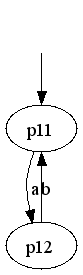

In [3]:
from util import plot_automaton

print('P1:')
plot_automaton(automaton=p1, file_name_no_extension='P1')  

P2:


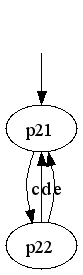

In [4]:
# We create a second automaton
p2 = Automaton(states={'p21', 'p22'},
               init='p21',
               events={'c', 'd', 'e'},
               trans={Transition('p21', 'c', 'p22'),
                      Transition('p22', 'd', 'p21'),
                      Transition('p22', 'e', 'p21')},
               marked={'p21', 'p22'})
print('P2:')
plot_automaton(p2, 'P2') # If this command is the last line in the cell, you can see the figure here!

- - -

# Task 1

## Task 1.1 - Reachability

Now that we know how to create automata, lets start with implementing the reachability function.

As defined in chapter 6 of the lecture notes the reachability algorithm is as follows:

**Algorithm 1.** Reachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q^+ \mid \exists q \in Q_{k-1} \wedge \exists \sigma \in \Sigma \wedge \delta(q,\sigma) = q^+ \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

This is a so called fix point operation.

* Describe in words how this algorithm works. You can enter your answer in the cell below. [Markdown](https://daringfireball.net/projects/markdown/syntax) and [LaTex's math environment](https://oeis.org/wiki/List_of_LaTeX_mathematical_symbols) (the \$ \$ environment) are supported. To edit the answer, double-click on "YOUR ANSWER HERE" in the cell below.

### Answer

The reachability function is an iterative method that makes use of a Breadth-first search (BFS) algorithm to visit all the reachable states in the graph.

The visited states set **Q_k** starts with the initial state of the automaton **Q_0**, unless if **Q_0** is a forbidden state, when the algorithm must return the empty set. 

For each iteration, the new **Q_k** will be equal to the union of the **Q_k** from the last iteration with all the states that are targeted by at least one origin belonging to the old **Q_k** (filtered by events that belong to the event set $\Sigma$).


The iteration stops when the visited states set **Q_k** do not change from iteration to another.
-

Here are some helper functions that might help you with your implementation of the algorithm in code.

In [5]:
def filter_trans_by_source(trans, states_to_keep):
    """Returns a new set containing all transitions where the source is in states_to_keep"""
    return {t for t in trans if t.source in states_to_keep}

def filter_trans_by_events(trans, events_to_keep):
    """Returns a new set containing all transitions where the event is in events_to_keep"""
    return {t for t in trans if t.event in events_to_keep}

def filter_trans_by_target(trans, states_to_keep):
    """Returns a new set containing all transitions where the target is in states_to_keep"""
    return {t for t in trans if t.target in states_to_keep}

def extract_elems_from_trans(trans, field):
    """ 
    Returns a new set with just the elements in a field of all transitions. 
    E.g. field='source' for all source states 
    or field='event' or field='target'
    """
    return {getattr(t, field) for t in trans}

def flip_trans(trans):
    """ Flips the direction of the transitions in the set"""
    return {Transition(t.target, t.event, t.source) for t in trans}

In [6]:
# Now implement the function in code
def reach(events, trans, start_states, forbidden):
    """
    Returns the forward reachable states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    Q = set()
    Q_new = start_states - forbidden
    while Q_new-Q:
        Q = Q_new
        next_trans = set(filter(lambda x: set([x.event]).issubset(events),set(filter_trans_by_source(trans,Q_new)) ))
        Q_new = Q_new | extract_elems_from_trans(next_trans,'target') - forbidden
    return Q_new

In [7]:
#################################################################################################################
#################################################################################################################
#################################################################################################################
# Single state
assert reach(set(), set(),{1}, set()) == {1}
assert reach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, set()) == {1, 2}
assert reach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1}
assert reach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert reach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1, 2}
assert reach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1}

# Handling of forbidden states
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2}) == {1}

# Larger automata
assert reach({'a'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
             {1},
             set()) == {1, 2, 3}
### BEGIN HIDDEN TESTS
assert reach({'a'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
             {1},
             {2}) == {1}, 'Error for forbidden state in 3-state automaton'
assert reach({'a'}, 
             {Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'a', 1)},
             {1},
             set()) == {1, 2}, 'Error for unknown event in 3-state automaton'
assert reach({'a', 'b', 'c'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), 
              Transition(2, 'b', 3), Transition(4, 'b', 3),
              Transition(3, 'a', 3), Transition(3, 'c', 1)},
             {1},
             set()) == {1, 2, 3}, 'Error for multiple transitions to state 3'
assert reach({'a', 'b', 'c'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), 
              Transition(2, 'b', 3), Transition(4, 'b', 3),
              Transition(3, 'a', 3), Transition(3, 'c', 1)},
             {1},
             {3}) == {1, 2}, 'Error for multiple transitions to forbidden state 3'
assert reach({'a', 'b', 'c'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 1), 
              Transition(3, 'b', 4), Transition(4, 'b', 3),
              Transition(3, 'c', 5), Transition(5, 'c', 3)},
             {1},
             set()) == {1, 2}, 'Error for split automaton'
assert reach({'a', 'b', 'c'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 1), 
              Transition(3, 'b', 4), Transition(4, 'b', 3),
              Transition(3, 'c', 5), Transition(5, 'c', 3)},
             {3},
             set()) == {3, 4, 5}, 'Error for split automaton'
### END HIDDEN TESTS

This below is a test cell. You can execute it to test your function with different inputs. The **assert** statements make sure that your function returns the expected results.

In [8]:
# Single state
assert reach(set(), set(),{1}, set()) == {1}
assert reach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, set()) == {1, 2}
assert reach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1}
assert reach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert reach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1, 2}
assert reach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1}

# Handling of forbidden states
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert reach({'a'}, {Transition(1, 'a', 2)}, {1}, {2}) == {1}

# Larger automata
assert reach({'a'}, 
             {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
             {1},
             set()) == {1, 2, 3}

## Task 1.2 - Coreachability

Similarly, the set of backwards reachable states is defined as:

**Algorithm 2.** BackwardReachability($\Sigma, \delta, Q_0, Q_x$)

>**let** $k:=0, Q_0 := Q_0 \setminus Q_x$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q \mid \exists \sigma \in \Sigma \wedge \delta(q,\sigma) \in Q_{k-1} \} \setminus Q_x $
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

* Implement Algorithm 2.

In [9]:
def coreach(events, trans, start_states, forbidden):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param events: set of events
    :param trans: set of transitions
    :param start_states: set of states
    :param forbidden: set of forbidden states
    """
    return reach(events, flip_trans(trans), start_states, forbidden)

In [10]:


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Single state
assert coreach(set(), set(),{1}, set()) == {1}
assert coreach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert coreach({'a'}, {Transition(2, 'a', 1)}, {2}, set()) == {2}
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1, 2}
assert coreach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert coreach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1}
assert coreach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1, 2}

# Handling of forbidden states
assert coreach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, {2}) == {1}

# Larger automata
assert coreach({'a'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
               {1},
               set()) == {1, 2, 3}
### BEGIN HIDDEN TESTS
assert coreach({'a'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
               {1},
               {2}) == {1, 3}, 'Error for forbidden state in 3-state automaton'
assert coreach({'a'}, 
               {Transition(1, 'a', 2), Transition(2, 'b', 3), Transition(3, 'a', 1)},
               {1},
               set()) == {1, 3}, 'Error for unknown event in 3-state automaton'
assert coreach({'a', 'b', 'c'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), 
                Transition(2, 'b', 3), Transition(4, 'b', 3),
                Transition(3, 'a', 3), Transition(3, 'c', 1)},
               {1},
               set()) == {1, 2, 3, 4}, 'Error for multiple transitions to state 3'
assert coreach({'a', 'b', 'c'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), 
                Transition(2, 'b', 3), Transition(4, 'b', 3),
                Transition(3, 'a', 3), Transition(3, 'c', 1)},
               {1},
               {3}) == {1}, 'Error for multiple transitions to forbidden state 3'
assert coreach({'a', 'b', 'c'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 1), 
                Transition(3, 'b', 4), Transition(4, 'b', 3),
                Transition(3, 'c', 5), Transition(5, 'c', 3)},
               {1},
               set()) == {1, 2}, 'Error for split automaton'
assert coreach({'a', 'b', 'c'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 1), 
                Transition(3, 'b', 4), Transition(4, 'b', 3),
                Transition(3, 'c', 5), Transition(5, 'c', 3)},
               {3},
               set()) == {3, 4, 5}, 'Error for split automaton'
### END HIDDEN TESTS

In [11]:
# Single state
assert coreach(set(), set(),{1}, set()) == {1}
assert coreach({'a'}, {Transition(1, 'a', 1)}, {1}, set()) == {1}

# Simple automata
assert coreach({'a'}, {Transition(2, 'a', 1)}, {2}, set()) == {2}
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, set()) == {1, 2}
assert coreach({'a'}, {Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}, set()) == {1, 2}

# Parallel transitions
assert coreach({'a', 'b'}, {Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}, set()) == {1}
assert coreach({'a', 'b'}, {Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}, set()) == {1, 2}

# Handling of forbidden states
assert coreach({'a'}, {Transition(1, 'a', 2)}, {1}, {1}) == set()
assert coreach({'a'}, {Transition(2, 'a', 1)}, {1}, {2}) == {1}

# Larger automata
assert coreach({'a'}, 
               {Transition(1, 'a', 2), Transition(2, 'a', 3), Transition(3, 'a', 1)},
               {1},
               set()) == {1, 2, 3}

## Task 1.3 - Synchronous composition
* Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.

* *Note:* The synchronization function can be implemented in different ways. We suggest to loop through all events, taking common and individual events for the two automata into account. In this event loop appropriate states are merged together according to the basic definition. A number of unreachable states will then be included.   
* *Note:* The synchronized function shall include the complete automaton, including any marked and forbidden states of the synchronized automaton.

Here are again some helper functions that might help you with your implementation of the algorithm in code.

In [12]:
def merge_label(label1, label2):
    """Creates a new label based on two labels"""
    return '{}.{}'.format(label1, label2)

def cross_product(setA, setB):
    """Computes the crossproduct of two sets"""
    return {merge_label(a, b) for b in setB for a in setA}

In [13]:
def synch(aut1, aut2):
    """
    Returns the synchronous composition of two automata.
    
    :param aut1: Automaton
    :param aut2: Automaton
    """
    def trim_unreach(aut12):
        aut12.states = reach(aut12.events,aut12.trans,{aut12.init},set())
        aut12.forbidden &= aut12.states
        aut12.marked &= aut12.states
        aut12.trans = set(filter(lambda x: set([x.source,x.target]).issubset(aut12.states), aut12.trans))
        return aut12
    
    events12 = extract_elems_from_trans(aut1.trans,'event') | extract_elems_from_trans(aut2.trans,'event')
    trans12 = set()
    for ev in events12:
        aut1.trans |= {Transition(st1, ev, st1) for st1 in aut1.states if ev not in aut1.events}
        aut2.trans |= {Transition(st1, ev, st1) for st1 in aut2.states if ev not in aut2.events}
        for tr1 in filter_trans_by_events( aut1.trans, {ev} ):
            for tr2 in filter_trans_by_events( aut2.trans, {ev} ):
                origin = merge_label( tr1.source, tr2.source )
                target = merge_label( tr1.target, tr2.target )
                trans12.add( Transition( origin, ev, target ) )
 
    init12      = merge_label(aut1.init, aut2.init)
    states12    = extract_elems_from_trans(trans12,'source') | extract_elems_from_trans(trans12,'target') | {init12}
    forbidden12 = cross_product(aut1.forbidden, aut2.states) | cross_product(aut1.states, aut2.forbidden) & states12
    marked12    = cross_product( aut1.marked if aut1.marked else aut1.states, aut2.marked if aut2.marked else aut2.states) & states12    
    return trim_unreach(Automaton( states=states12, init=init12, events=events12, trans=trans12, forbidden=forbidden12, marked=marked12 ))

In [14]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 1.1
assert a1a2.init == '1.2' # TC - 1.2
assert a1a2.events == set() # TC - 1.3
assert a1a2.trans == set() # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 2.1
assert a1a2.init == '1.2' # TC - 2.2
assert a1a2.events == set() # TC - 2.3
assert a1a2.trans == set() # TC - 2.4
assert a1a2.marked == {'1.2'} # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 3.1
assert a1a2.init == '1.2' # TC - 3.2
assert a1a2.events == set() # TC - 3.3
assert a1a2.trans == set() # TC - 3.4
assert a1a2.forbidden == {'1.2'} # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 4.1
assert a1a2.init == '1.3' # TC - 4.2
assert a1a2.events == {'a'} # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 4.4
assert a1a2.marked == {'2.3'} # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 5.1
assert a1a2.init == '1.3' # TC - 5.2
assert a1a2.events == {'a'} # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 5.5
assert a1a2.forbidden == {'2.3'} # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 6.1
assert a1a2.init == '1.3' # TC - 6.2
assert a1a2.events == {'a', 'b'} # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC -6.4
assert a1a2.marked == {'2.3', '2.4'} # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'} # TC - 7.1
assert a1a2.init == '1.3' # TC - 7.2
assert a1a2.events == {'a'} # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')} # TC - 7.4
assert a1a2.marked == {'2.4'} # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 8.1
assert a1a2.init == '1.3' # TC - 8.2
assert a1a2.events == {'a', 'b'} # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'} # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 9.1
assert a1a2.init == '1.3' # TC - 9.2
assert a1a2.events == {'a', 'b'} # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 9.4
assert a1a2.marked == {'2.3'} # TC - 9.5

### BEGIN HIDDEN TESTS
# Different symbols
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1, 2},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd'},
               init='c',
               events={2},
               trans={Transition('c', 2, 'd')})
b1b2 = synch(b1, b2)
assert b1b2.states == {'a.c', 'b.c'}, 'Different symbols should not cause error!'
assert b1b2.init == 'a.c', 'Different symbols should not cause error!'
assert b1b2.events == {1, 2}, 'Different symbols should not cause error!'
assert b1b2.trans == {Transition('a.c', 1, 'b.c')}, 'Different symbols should not cause error!'
assert b1b2.marked == {'b.c'}, 'Different symbols should not cause error!'

# Bigger automata
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd', 'e'},
               init='c',
               events={1, 2},
               trans={Transition('c', 1, 'd'), Transition('d', 2, 'e'), Transition('e', 1, 'c')})
b1b2 = synch(b1, b2)
assert b1b2.states == {'a.c', 'b.e', 'b.d'}, 'Shared events'
assert b1b2.init == 'a.c', 'Shared events'
assert b1b2.events == {1, 2}, 'Shared events'
assert b1b2.trans == {Transition('a.c', 1, 'b.d'), Transition('b.d', 2, 'b.e')}, 'Shared events'
assert b1b2.marked == {'b.e', 'b.d'}, 'Shared events'

b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1},
               trans={Transition('a', 1, 'b'), Transition('b', 1, 'a')},
               marked={'b'})
b2 = Automaton(states={'c', 'd', 'e'},
               init='c',
               events={1, 2},
               trans={Transition('c', 1, 'd'), Transition('d', 2, 'e'), Transition('e', 1, 'c')})
b1b2 = synch(b1, b2)
assert b1b2.states == {'a.c', 'b.e', 'b.d'}, 'Loops'
assert b1b2.init == 'a.c', 'Loops'
assert b1b2.events == {1, 2}, 'Loops'
assert b1b2.trans == {Transition('a.c', 1, 'b.d'), Transition('b.d', 2, 'b.e'), Transition('b.e', 1, 'a.c')}, 'Loops'
assert b1b2.marked == {'b.e', 'b.d'}, 'Loops'
### END HIDDEN TESTS

In [15]:
# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 1.1
assert a1a2.init == '1.2' # TC - 1.2
assert a1a2.events == set() # TC - 1.3
assert a1a2.trans == set() # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 2.1
assert a1a2.init == '1.2' # TC - 2.2
assert a1a2.events == set() # TC - 2.3
assert a1a2.trans == set() # TC - 2.4
assert a1a2.marked == {'1.2'} # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'} # TC - 3.1
assert a1a2.init == '1.2' # TC - 3.2
assert a1a2.events == set() # TC - 3.3
assert a1a2.trans == set() # TC - 3.4
assert a1a2.forbidden == {'1.2'} # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 4.1
assert a1a2.init == '1.3' # TC - 4.2
assert a1a2.events == {'a'} # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 4.4
assert a1a2.marked == {'2.3'} # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 5.1
assert a1a2.init == '1.3' # TC - 5.2
assert a1a2.events == {'a'} # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 5.5
assert a1a2.forbidden == {'2.3'} # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 6.1
assert a1a2.init == '1.3' # TC - 6.2
assert a1a2.events == {'a', 'b'} # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC -6.4
assert a1a2.marked == {'2.3', '2.4'} # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'} # TC - 7.1
assert a1a2.init == '1.3' # TC - 7.2
assert a1a2.events == {'a'} # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')} # TC - 7.4
assert a1a2.marked == {'2.4'} # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'} # TC - 8.1
assert a1a2.init == '1.3' # TC - 8.2
assert a1a2.events == {'a', 'b'} # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition('1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')} # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'} # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'} # TC - 9.1
assert a1a2.init == '1.3' # TC - 9.2
assert a1a2.events == {'a', 'b'} # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')} # TC - 9.4
assert a1a2.marked == {'2.3'} # TC - 9.5


- - -

# Task 2

Consider the following two plant models given by the formal languages

<center>
    $L(P_1) = \overline{(ab)^*} \\
    L(P_2) = \overline{(c(d+e))^*}$

and the marked specification languages 

<center>
    $L(Sp_1) = (bc)^* \\
    L(Sp_2) = (cd)^*$
    
and the synchronised system

<center>
    $S = P_1 \parallel P_2 \parallel Sp_1 \parallel Sp_2$
    
The plant models are already defined as automaton ***p1*** and ***p2*** above.

## Task 2.1 - Petri Net

* Formulate a Petri net for the synchronized sytem *S*  
* and generate the corresponding reachability graph.
* *Note:* It might be easier to first draw those with a pen on paper and then transfer it into the notebook.

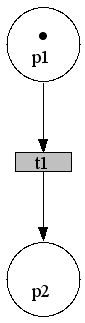

In [16]:
from util import plot_petrinet

PetriNet = namedtuple(typename='PetriNet', field_names=['places', 'transitions', 'arcs'])
Place = namedtuple('Place', ['label', 'marking'])
Arc = namedtuple('Arc', ['source', 'target', 'weight'])

# You can use the ploting function to plot your petri net for S
example = PetriNet(places={Place('p1', 1), Place('p2', 0)}, 
                   transitions={'t1'}, 
                   arcs={Arc('p1', 't1', 1), Arc('t1', 'p2', 1)})
plot_petrinet(example, 'example')

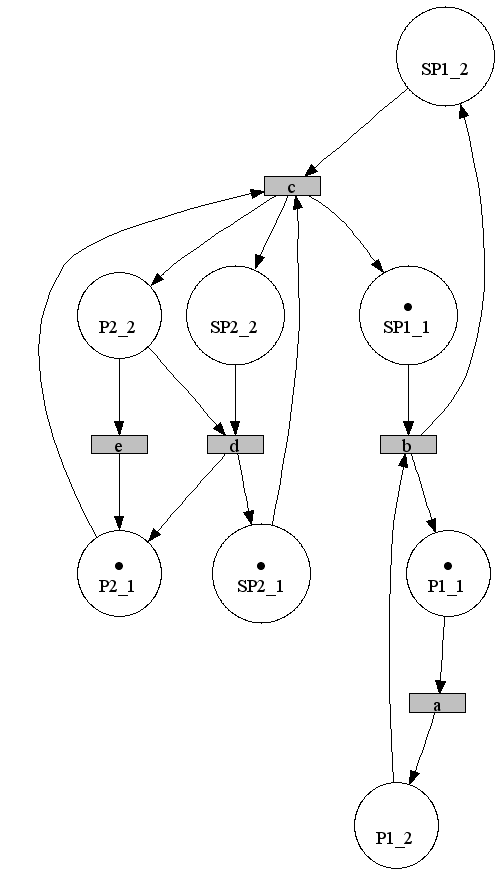

In [17]:
def make_synchronized_petri_net_S():
    """
    A little helper function to create the Petri net of S.
    
    You can just hard code the elements of the net just like in the example above.
    We will call this function later in the tests.
    """
    result = PetriNet(places={Place('P1_1', 1), Place('P1_2', 0),
                              Place('P2_1', 1), Place('P2_2', 0),
                              Place('SP1_1', 1), Place('SP1_2', 0),
                              Place('SP2_1', 1), Place('SP2_2', 0)}, 
                       transitions={'a', 'b', 'c', 'd', 'e'}, 
                       arcs={Arc('P1_1', 'a', 1), Arc('a', 'P1_2', 1), Arc('P1_2', 'b', 1), Arc('b', 'P1_1', 1),
                             Arc('P2_1', 'c', 1), Arc('c', 'P2_2', 1), Arc('P2_2', 'e', 1), Arc('e', 'P2_1', 1), Arc('P2_2', 'd', 1), Arc('d', 'P2_1', 1),
                             Arc('SP1_1', 'b', 1), Arc('b', 'SP1_2', 1), Arc('SP1_2', 'c', 1), Arc('c', 'SP1_1', 1),
                             Arc('SP2_1', 'c', 1), Arc('c', 'SP2_2', 1), Arc('SP2_2', 'd', 1), Arc('d', 'SP2_1', 1)})
    return result

S = make_synchronized_petri_net_S()
plot_petrinet(S, 'S')

In [18]:
##################################################################################################################
##################################################################################################################
##################################################################################################################

S = make_synchronized_petri_net_S()
assert isinstance(S, PetriNet)
assert isinstance(S.places.pop(), Place)
assert isinstance(S.arcs.pop(), Arc)

### BEGIN HIDDEN TESTS
S = make_synchronized_petri_net_S()
assert len(S.places) == 8
assert len(S.transitions) == 5
assert len(S.arcs) == 18
### END HIDDEN TESTS

In [19]:
S = make_synchronized_petri_net_S()
assert isinstance(S, PetriNet)
assert isinstance(S.places.pop(), Place)
assert isinstance(S.arcs.pop(), Arc)


Similarly, we create the reachability graph.

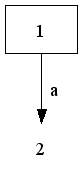

In [20]:
from util import plot_digraph

DiGraph = namedtuple(typename='DiGraph', field_names=['nodes', 'init', 'edges'])
Edge = namedtuple('Edge', ['source', 'target', 'label'])

# You can use the ploting function to plot your reachability graph for S
example = DiGraph(nodes={1, 2},
                  init=1,
                  edges={Edge(1, 2, 'a')})
plot_digraph(example, 'example')

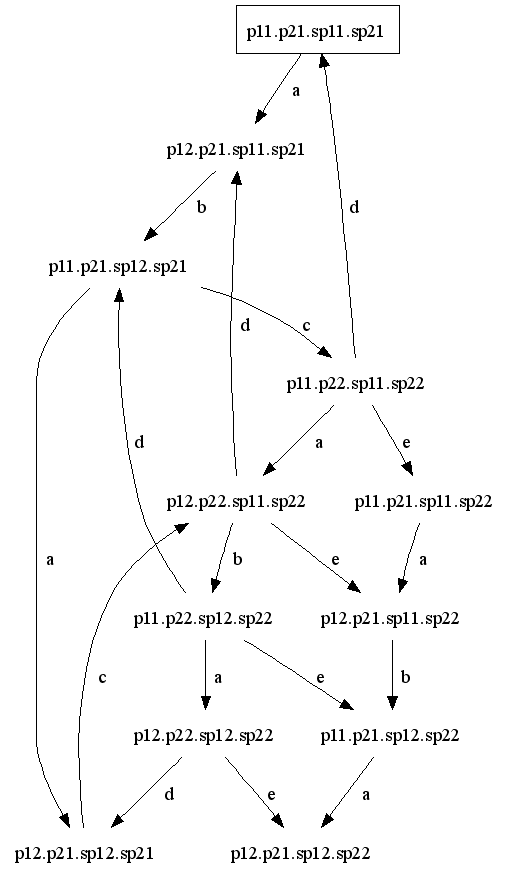

In [21]:
def make_reachability_graph():
    """
    A little helper function to create the reachability graph of S.
    
    You can just hard code the elements of the graph just like in the example above.
    We will call this function later in the tests.
    """
    from functools import reduce
    import numpy as np

    Am = np.matrix([[1, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 0, 1, 1],
                    [0, 1, 0, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 0, 0, 1, 0]])
    Ap = np.matrix([[0, 1, 0, 0, 0],
                    [1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1],
                    [0, 0, 1, 0, 0],
                    [0, 0, 1, 0, 0],
                    [0, 1, 0, 0, 0],
                    [0, 0, 0, 1, 0],
                    [0, 0, 1, 0, 0]])
    m = np.matrix([[1,0,1,0,1,0,1,0]]).T

    def m2t(m): return tuple(m.T.tolist()[0])
    def t2m(t): return np.matrix(t).T

    def reach_graph(Ap, Am, m, diGraph):
        next_edge = [(m - Am[:,i]).min()>=0 for i in range( Am.shape[1] )]
        next_edge_set = [i for i,x in enumerate(next_edge) if x]
        next_nodes = [m - Am[:,i] + Ap[:,i]  for i,x in enumerate(next_edge) if x]  
        next_node_set = set([m2t(mk) for mk in next_nodes])

        new_diGraph = DiGraph(nodes= diGraph.nodes | next_node_set,
                              init=  diGraph.init, 
                              edges= diGraph.edges | {Edge(m2t(m), m2t(target), next_edge_set[i]) for i,target in enumerate(next_nodes)})

        dlist = [reach_graph(Ap, Am, t2m(nn), new_diGraph) for nn in list(next_node_set-diGraph.nodes)]

        new_nodes = new_diGraph.nodes | reduce(lambda x,y:x|y, [x.nodes for x in dlist], set())
        new_edges = new_diGraph.edges | reduce(lambda x,y:x|y, [x.edges for x in dlist], set())
        return DiGraph(nodes=new_nodes, init=diGraph.init, edges=new_edges)

    diGraph = DiGraph(nodes=set([tuple(m.T.tolist()[0])]), init=tuple(m.T.tolist()[0]), edges=set())
    diGraph = reach_graph(Ap, Am, m, diGraph)
    
    # Change state and event FROM NUMBERS to LETTERS. Then return
    chgNode = lambda tupl: reduce(lambda s1,s2: str(s1)+'.'+str(s2), [['p11','p12','p21','p22','sp11','sp12','sp21','sp22'][i] for i,n in enumerate(tupl) if n])
    return DiGraph(nodes= set(map(lambda x: chgNode(x), diGraph.nodes)),
                   init = chgNode(diGraph.init),
                   edges= set(map(lambda x: Edge(chgNode(x[0]),chgNode(x[1]),'abcde'[x[2]]), diGraph.edges)) )

plot_digraph(make_reachability_graph(), 'S_reach_graph')

In [22]:
G = make_reachability_graph()
assert isinstance(G, DiGraph)
assert isinstance(G.nodes, set)
assert isinstance(G.edges.pop(), Edge)


In [23]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################

G = make_reachability_graph()
assert isinstance(G, DiGraph)
assert isinstance(G.nodes, set)
assert isinstance(G.edges.pop(), Edge)

### BEGIN HIDDEN TESTS
G = make_reachability_graph()
assert len(G.nodes) == 12
assert len(G.edges) == 19
### END HIDDEN TESTS

## Task 2.2 - Synchronized Automaton

* Generate the automaton for the synchronized system *S* by the implemented functions `synch`, 
* and compare the results with the reachbility graph in **2.1**.

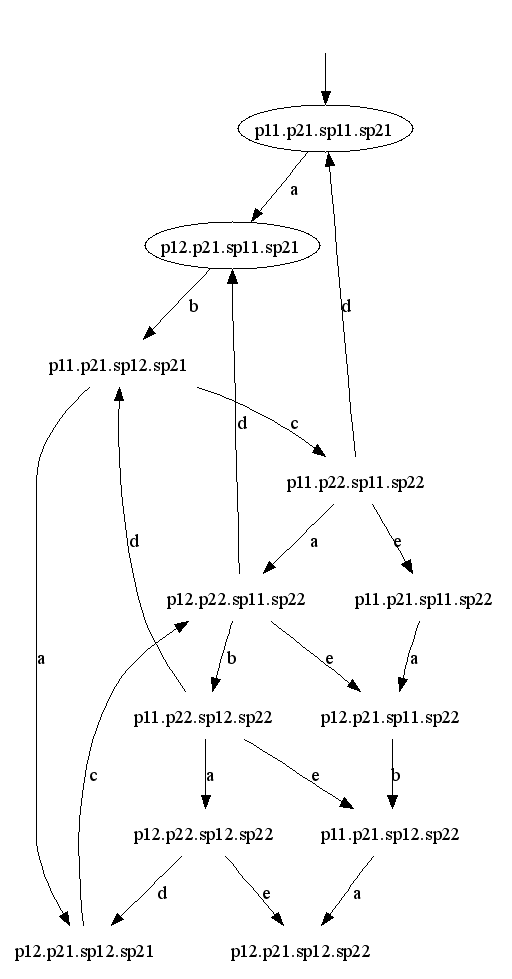

In [24]:
def make_synchronized_automaton_S():
    """
    A little helper function to create the automaton of S.
    
    Define the automata sp1 and sp2 in here too.
    We will call this function later in the tests.
    """
    sp1 = Automaton(states={'sp11', 'sp12'},
               init='sp11',
               events={'c','b'},
               trans={Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')},
               marked={'sp11'})
    sp2 = Automaton(states={'sp21', 'sp22'},
               init='sp21',
               events={'c','d'},
               trans={Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21')},
               marked={'sp21'} )
    S = synch(synch(synch(p1, p2),sp1),sp2)
    return S

S = make_synchronized_automaton_S()
display(plot_automaton(S, 'P1P2SP1SP2'))

In [25]:
S = make_synchronized_automaton_S()
assert S.init == 'p11.p21.sp11.sp21', 'Please, follow the synchronization order specified in Task 2!'


Compare the synchronized automaton of *S* to the reachability graph.

### Answer:

As can be very easily seen, both synchronized automaton and reachability graph are exactly the same.

We have achieved this by calculating the reachability graph and then mapping each State Tuple to the respective name 

* example: (10101010) $\rightarrow$ (p11.p21.sp11.sp21). 

The same has been made for the events. 

The only difference between the two graphs, is that in the reachability graph no marked state was drawn. That happens because the class DiGraph does not have a field for marked or forbidden states. Such property could have been added, enabling the calculation and representation of synchronized marked and forbidden states.  

## Task 2.3 - Blocking states

* Calculate the reachable and coreachable states in *S* by the implemented functions `reach` and `coreach`, and identify blocking states (states from where no marked state can be reached).

In [26]:
reachable = reach(S.events, S.trans, set([S.init]), S.forbidden)
coreachable = coreach(S.events, S.trans, S.marked, S.forbidden)
blocking = S.states - (reachable & coreachable)

print('The blocking states are: ', blocking)

The blocking states are:  {'p12.p21.sp11.sp22', 'p12.p21.sp12.sp22', 'p11.p21.sp12.sp22', 'p11.p21.sp11.sp22'}


In [27]:
assert reachable is not None
assert coreachable is not None
assert blocking is not None

### BEGIN HIDDEN TESTS
assert reachable != coreachable
assert blocking == {'p11.p21.sp11.sp22', 'p12.p21.sp11.sp22', 'p12.p21.sp12.sp22', 'p11.p21.sp12.sp22'}
### END HIDDEN TESTS

In [28]:
assert reachable is not None
assert coreachable is not None
assert blocking is not None


## Task 2.4 - Modified Spec

* Modify the specifications to avoid the blocking states, and verify that no blocking states are achieved by showing that the reachable and coreachable states of *S* are the same for the modified specifications.
* Explain your modifications first in natural language.

### Answer

As noticed in the synchronized automaton as well as in the reachability graph, there are 4 forbidden states. As can be easily seen, all of them have in common that they are called by and only by the same event **e** and also by and only by synchronized states where **p22** is active, i.e. (**%%.%%.%%.p22**).

The solution then turns out to be simple, once we only need to avoid all synchronized states (**%%.%%.%%.p22**) from calling **e**. To do so, we only need to add the event **e** to the alphabet of Sp2. In this way, we will avoid **Sp22** from calling **e**.

-

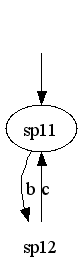

In [29]:
sp1_new = Automaton(states={'sp11', 'sp12'},
                   init='sp11',
                   events={'c','b'},
                   trans={Transition('sp11', 'b', 'sp12'), Transition('sp12', 'c', 'sp11')},
                   marked={'sp11'})

plot_automaton(sp1_new, 'SP1_new') 

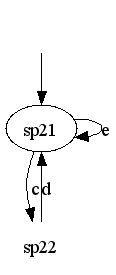

In [30]:
sp2_new = Automaton(states={'sp21', 'sp22'},
                   init='sp21',
                   events={'c','d','e'},
                   trans={Transition('sp21', 'c', 'sp22'), Transition('sp22', 'd', 'sp21'), Transition('sp21', 'e', 'sp21')},
                   marked={'sp21'} )

plot_automaton(sp2_new, 'SP2_new') 

The blocking states now are:  set()


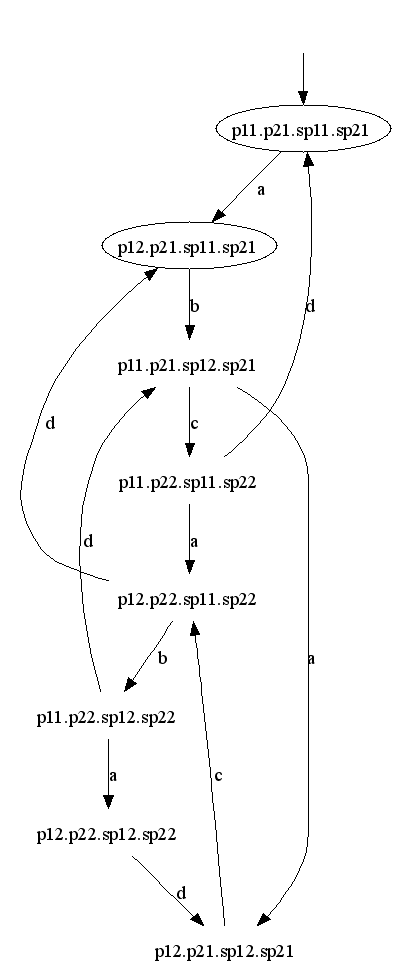

In [31]:
# Now synchronize with the new specifications
S_new = synch(synch(p1, p2), synch(sp1_new, sp2_new))

reachable_new = reach(S_new.events, S_new.trans, set([S_new.init]), S_new.forbidden)
coreachable_new = coreach(S_new.events, S_new.trans, S_new.marked, S_new.forbidden) 
blocking_new = S_new.states - (reachable & coreachable)

print('The blocking states now are: ', blocking_new)
plot_automaton(S_new, 'S_new') 

In [32]:
assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None


In [33]:
####################################################################################################################################
####################################################################################################################################
####################################################################################################################################

assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None

### BEGIN HIDDEN TESTS
assert blocking_new == set()
assert reachable_new == coreachable_new
assert len(S_new.states) == 8, 'Incorrect number of states. Of by {}'.format(len(S_new.states) - 8)
assert len(S_new.events) == 5, 'Incorrect number of events. Of by {}'.format(len(S_new.events) - 5)
assert len(S_new.trans) == 12, 'Incorrect number of transitions. Of by {}'.format(len(S_new.trans) - 12)
assert len(S_new.marked) == 2, 'Incorrect number of marked states. Of by {}'.format(len(S_new.marked) - 2)
### END HIDDEN TESTS

- - -

Congratulations! You have reached the end of the assignment. Now,

* Save the notebook
* Upload the .ipynb file to Ping Pong
* Enjoy the rest of the day! 